# 模型评估与选择 (Model Evaluation & Selection)

## 学习目标
- 深入理解各种评估指标
- 掌握ROC曲线和AUC的含义
- 理解PR曲线的应用场景
- 掌握多种交叉验证策略
- 使用学习曲线诊断模型
- 进行系统化的超参数调优
- 学会模型选择的最佳实践
- 完成综合实战项目

**预计学习时间：** 4-5小时

---

## 1. 评估指标深入

### 1.1 回顾：混淆矩阵

混淆矩阵是理解所有分类指标的基础：

|  | 预测为负类 | 预测为正类 |
|---|-----------|----------|
| **实际为负类** | TN | FP (第一类错误) |
| **实际为正类** | FN (第二类错误) | TP |

---

### 1.2 基本指标

#### 准确率 (Accuracy)
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**优点**: 简单直观  
**缺点**: 类别不平衡时具有误导性

---

#### 精确率 (Precision)
$$Precision = \frac{TP}{TP + FP}$$

**含义**: 预测为正类的样本中，真正为正类的比例  
**问题**: 当假阳性代价高时优先考虑（如垃圾邮件检测）

---

#### 召回率 (Recall / Sensitivity / TPR)
$$Recall = \frac{TP}{TP + FN}$$

**含义**: 实际为正类的样本中，被正确预测的比例  
**问题**: 当假阴性代价高时优先考虑（如疾病诊断）

---

#### F1分数
$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

**含义**: 精确率和召回率的调和平均数  
**用途**: 综合考虑两者，适合类别不平衡

---

#### F-beta分数
$$F_\beta = (1 + \beta^2) \times \frac{Precision \times Recall}{\beta^2 \times Precision + Recall}$$

- $\beta > 1$: 更重视召回率
- $\beta < 1$: 更重视精确率
- $\beta = 1$: F1分数

---

### 1.3 多分类指标

**宏平均 (Macro Average)**:
- 对每个类别计算指标，然后取平均
- 对所有类别同等对待

**微平均 (Micro Average)**:
- 先汇总所有类别的TP、FP、FN
- 然后计算指标
- 受样本数多的类别影响大

**加权平均 (Weighted Average)**:
- 按类别样本数加权平均
- 考虑类别不平衡

---

## 2. 导入必要的库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    validation_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',
    'PingFang SC',
    'STHeiti',
    'Heiti TC',
    'SimHei',
]
plt.rcParams['axes.unicode_minus'] = False

print('✓ 所有库导入成功')

✓ 所有库导入成功


## 3. 类别不平衡问题演示

### 3.1 生成不平衡数据集

类别分布:
  训练集 - 负类: 718, 正类: 82
  测试集 - 负类: 180, 正类: 20
  正类占比: 10.2%


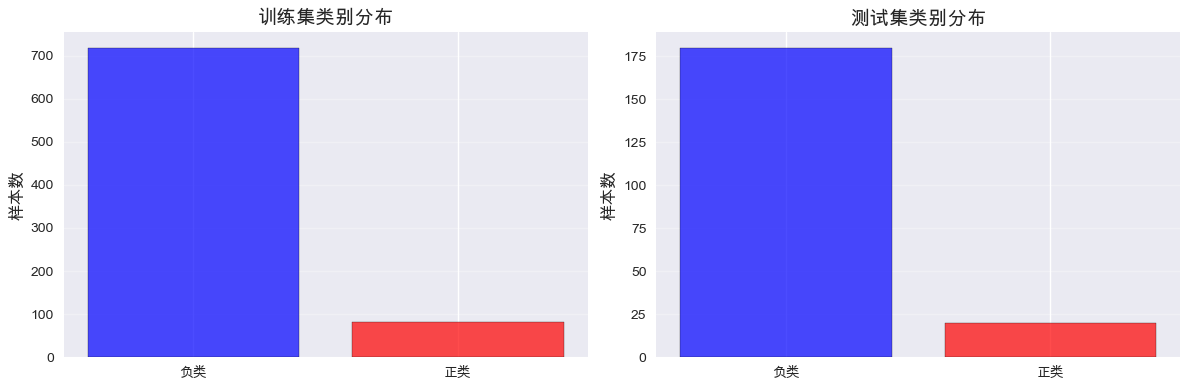

In [2]:
# 生成类别不平衡的数据集（正类:负类 = 1:9）
X_imb, y_imb = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    weights=[0.9, 0.1],  # 90%负类，10%正类
    random_state=42
)

# 划分数据集
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.2, random_state=42, stratify=y_imb
)

print('类别分布:')
print(f'  训练集 - 负类: {np.sum(y_train_imb==0)}, 正类: {np.sum(y_train_imb==1)}')
print(f'  测试集 - 负类: {np.sum(y_test_imb==0)}, 正类: {np.sum(y_test_imb==1)}')
print(f'  正类占比: {np.sum(y_imb==1)/len(y_imb)*100:.1f}%')

# 可视化类别分布
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 训练集
axes[0].bar(['负类', '正类'], [np.sum(y_train_imb==0), np.sum(y_train_imb==1)],
            color=['blue', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('样本数', fontsize=12)
axes[0].set_title('训练集类别分布', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')

# 测试集
axes[1].bar(['负类', '正类'], [np.sum(y_test_imb==0), np.sum(y_test_imb==1)],
            color=['blue', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('样本数', fontsize=12)
axes[1].set_title('测试集类别分布', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 3.2 准确率的误导性

评估指标:
  准确率 (Accuracy):  0.9350
  精确率 (Precision): 0.8182
  召回率 (Recall):    0.4500
  F1分数:             0.5806


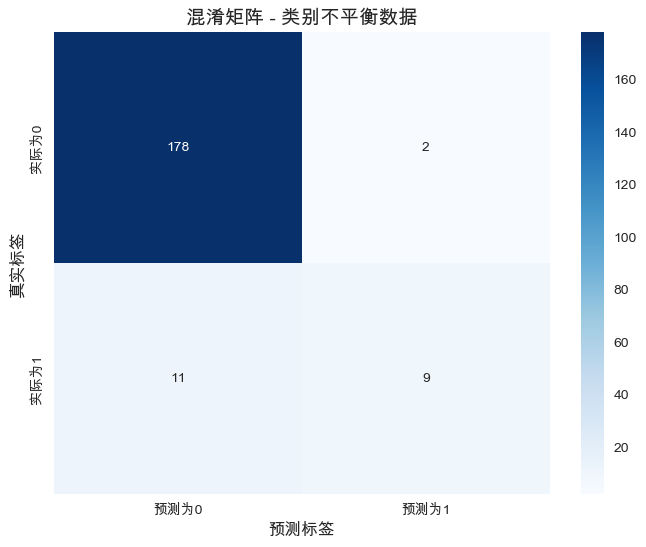


混淆矩阵分析:
  TN (真负类): 178
  FP (假正类): 2
  FN (假负类): 11
  TP (真正类): 9

关键观察:
  - 准确率 93.5% 看起来很高
  - 但如果全部预测为负类，准确率也能达到 90.0%
  - F1分数 0.5806 更能反映真实性能


In [3]:
# 训练一个简单的逻辑回归模型
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_imb, y_train_imb)

# 预测
y_pred_imb = lr.predict(X_test_imb)

# 计算各种指标
accuracy = accuracy_score(y_test_imb, y_pred_imb)
precision = precision_score(y_test_imb, y_pred_imb)
recall = recall_score(y_test_imb, y_pred_imb)
f1 = f1_score(y_test_imb, y_pred_imb)

print('评估指标:')
print(f'  准确率 (Accuracy):  {accuracy:.4f}')
print(f'  精确率 (Precision): {precision:.4f}')
print(f'  召回率 (Recall):    {recall:.4f}')
print(f'  F1分数:             {f1:.4f}')

# 混淆矩阵
cm = confusion_matrix(y_test_imb, y_pred_imb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测为0', '预测为1'],
            yticklabels=['实际为0', '实际为1'])
plt.ylabel('真实标签', fontsize=12)
plt.xlabel('预测标签', fontsize=12)
plt.title('混淆矩阵 - 类别不平衡数据', fontsize=14)
plt.show()

tn, fp, fn, tp = cm.ravel()

print('\n混淆矩阵分析:')
print(f'  TN (真负类): {tn}')
print(f'  FP (假正类): {fp}')
print(f'  FN (假负类): {fn}')
print(f'  TP (真正类): {tp}')

print('\n关键观察:')
print(f'  - 准确率 {accuracy:.1%} 看起来很高')
print(f'  - 但如果全部预测为负类，准确率也能达到 {np.sum(y_test_imb==0)/len(y_test_imb):.1%}')
print(f'  - F1分数 {f1:.4f} 更能反映真实性能')

## 4. ROC曲线和AUC

### 4.1 ROC曲线原理

**ROC (Receiver Operating Characteristic) 曲线：**
- X轴：假正类率 (FPR) = $\frac{FP}{FP + TN}$
- Y轴：真正类率 (TPR) = $\frac{TP}{TP + FN}$ (即召回率)
- 通过改变分类阈值绘制曲线

**AUC (Area Under Curve)：**
- ROC曲线下的面积
- 范围：[0, 1]
- 含义：随机正样本的预测概率 > 随机负样本的概率
- AUC = 0.5: 随机猜测
- AUC = 1.0: 完美分类器

---

### 4.2 绘制ROC曲线

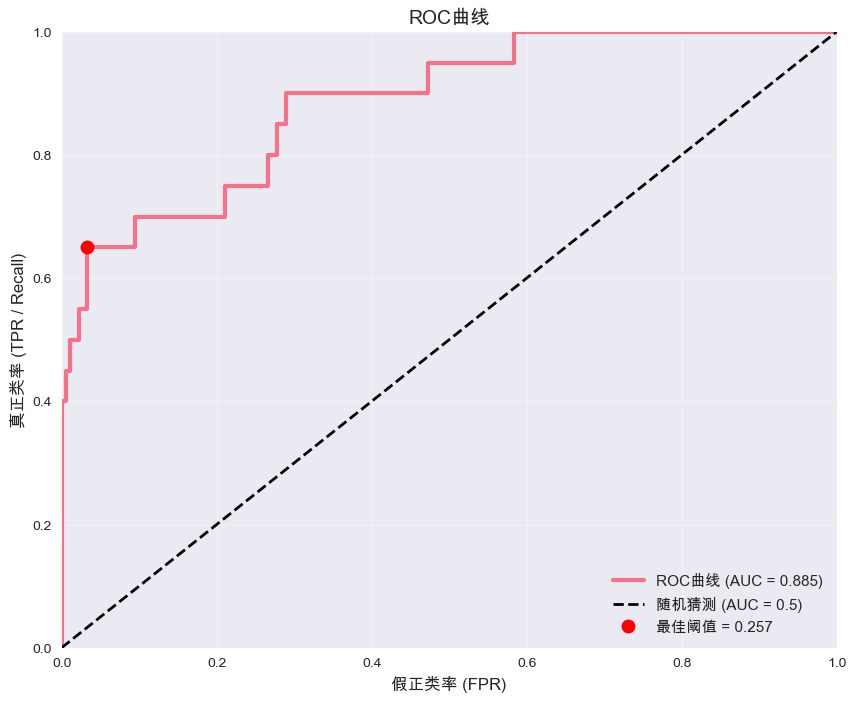

AUC分数: 0.8850
最佳阈值: 0.2571
  对应的TPR: 0.6500
  对应的FPR: 0.0333


In [4]:
# 获取预测概率
y_pred_proba = lr.predict_proba(X_test_imb)[:, 1]

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_test_imb, y_pred_proba)
auc_score = roc_auc_score(y_test_imb, y_pred_proba)

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=3, label=f'ROC曲线 (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='随机猜测 (AUC = 0.5)')

# 标记最佳阈值点（Youden's J statistic）
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
         label=f'最佳阈值 = {optimal_threshold:.3f}')

plt.xlabel('假正类率 (FPR)', fontsize=12)
plt.ylabel('真正类率 (TPR / Recall)', fontsize=12)
plt.title('ROC曲线', fontsize=14)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print(f'AUC分数: {auc_score:.4f}')
print(f'最佳阈值: {optimal_threshold:.4f}')
print(f'  对应的TPR: {tpr[optimal_idx]:.4f}')
print(f'  对应的FPR: {fpr[optimal_idx]:.4f}')

### 4.3 阈值对指标的影响

In [5]:
# 测试不同阈值
thresholds_to_test = [0.3, 0.5, 0.7, 0.9]

print('不同阈值的影响:')
print('='*80)
print(f'{"阈值":<10} {"准确率":<12} {"精确率":<12} {"召回率":<12} {"F1分数":<12}')
print('-'*80)

for threshold in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    acc = accuracy_score(y_test_imb, y_pred_thresh)
    prec = precision_score(y_test_imb, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test_imb, y_pred_thresh)
    f1 = f1_score(y_test_imb, y_pred_thresh, zero_division=0)
    
    print(f'{threshold:<10.2f} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}')

print('='*80)
print('\n观察:')
print('  - 阈值降低: 召回率↑，精确率↓')
print('  - 阈值升高: 精确率↑，召回率↓')
print('  - 需要根据业务需求选择合适的阈值')

不同阈值的影响:
阈值         准确率          精确率          召回率          F1分数        
--------------------------------------------------------------------------------
0.30       0.9250       0.6471       0.5500       0.5946      
0.50       0.9350       0.8182       0.4500       0.5806      
0.70       0.9350       1.0000       0.3500       0.5185      
0.90       0.9200       1.0000       0.2000       0.3333      

观察:
  - 阈值降低: 召回率↑，精确率↓
  - 阈值升高: 精确率↑，召回率↓
  - 需要根据业务需求选择合适的阈值


### 4.4 多个模型的ROC对比

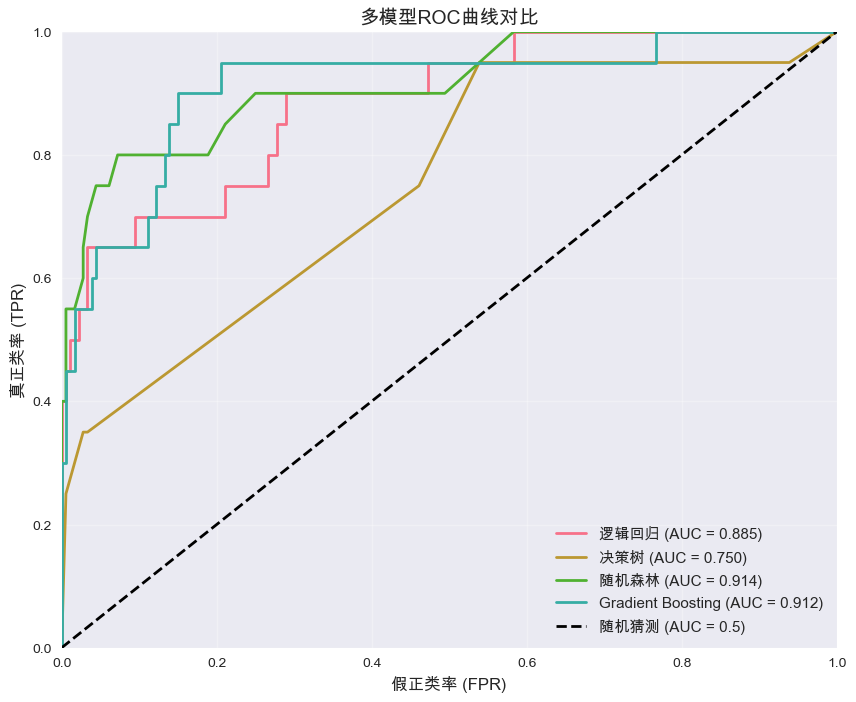

In [6]:
# 训练多个模型
models = {
    '逻辑回归': LogisticRegression(random_state=42, max_iter=1000),
    '决策树': DecisionTreeClassifier(max_depth=5, random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # 训练
    model.fit(X_train_imb, y_train_imb)
    
    # 预测概率
    y_proba = model.predict_proba(X_test_imb)[:, 1]
    
    # 计算ROC
    fpr, tpr, _ = roc_curve(y_test_imb, y_proba)
    auc = roc_auc_score(y_test_imb, y_proba)
    
    # 绘制
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='随机猜测 (AUC = 0.5)')
plt.xlabel('假正类率 (FPR)', fontsize=12)
plt.ylabel('真正类率 (TPR)', fontsize=12)
plt.title('多模型ROC曲线对比', fontsize=14)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

## 5. PR曲线 (Precision-Recall Curve)

### 5.1 PR曲线原理

**PR曲线：**
- X轴：召回率 (Recall)
- Y轴：精确率 (Precision)
- 通过改变分类阈值绘制

**何时使用PR曲线？**
- 类别高度不平衡时
- 更关注正类的表现
- ROC曲线可能过于乐观

**AP (Average Precision)：**
- PR曲线下的面积
- 对不平衡数据更敏感

---

### 5.2 绘制PR曲线

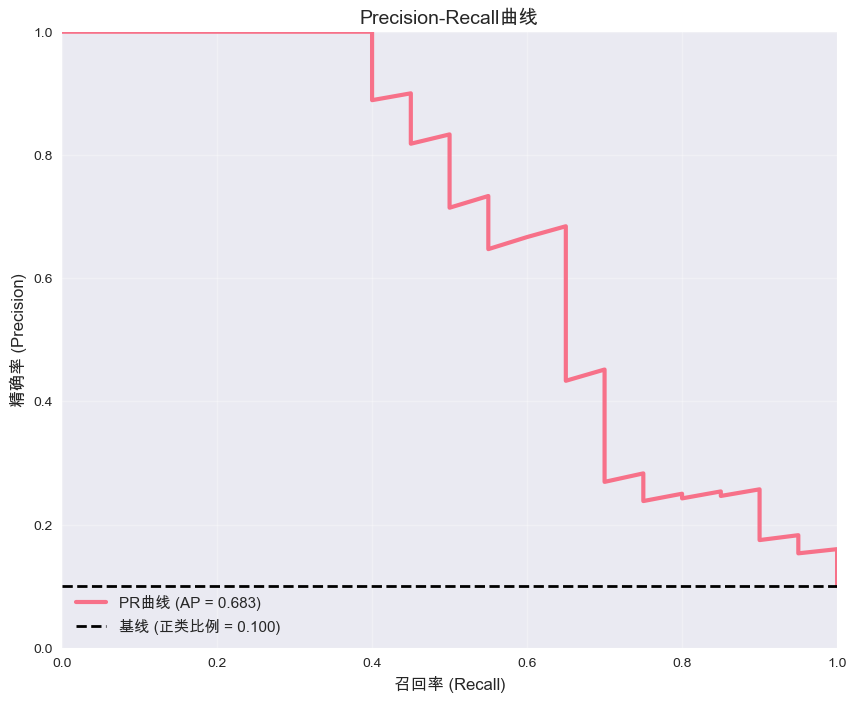

Average Precision: 0.6828
基线（正类比例）: 0.1000


In [7]:
# 计算PR曲线
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(
    y_test_imb, y_pred_proba
)
ap_score = average_precision_score(y_test_imb, y_pred_proba)

# 绘制PR曲线
plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, linewidth=3,
         label=f'PR曲线 (AP = {ap_score:.3f})')

# 基线（正类比例）
baseline = np.sum(y_test_imb == 1) / len(y_test_imb)
plt.axhline(y=baseline, color='k', linestyle='--', linewidth=2,
            label=f'基线 (正类比例 = {baseline:.3f})')

plt.xlabel('召回率 (Recall)', fontsize=12)
plt.ylabel('精确率 (Precision)', fontsize=12)
plt.title('Precision-Recall曲线', fontsize=14)
plt.legend(fontsize=11, loc='lower left')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print(f'Average Precision: {ap_score:.4f}')
print(f'基线（正类比例）: {baseline:.4f}')

### 5.3 ROC vs PR曲线对比

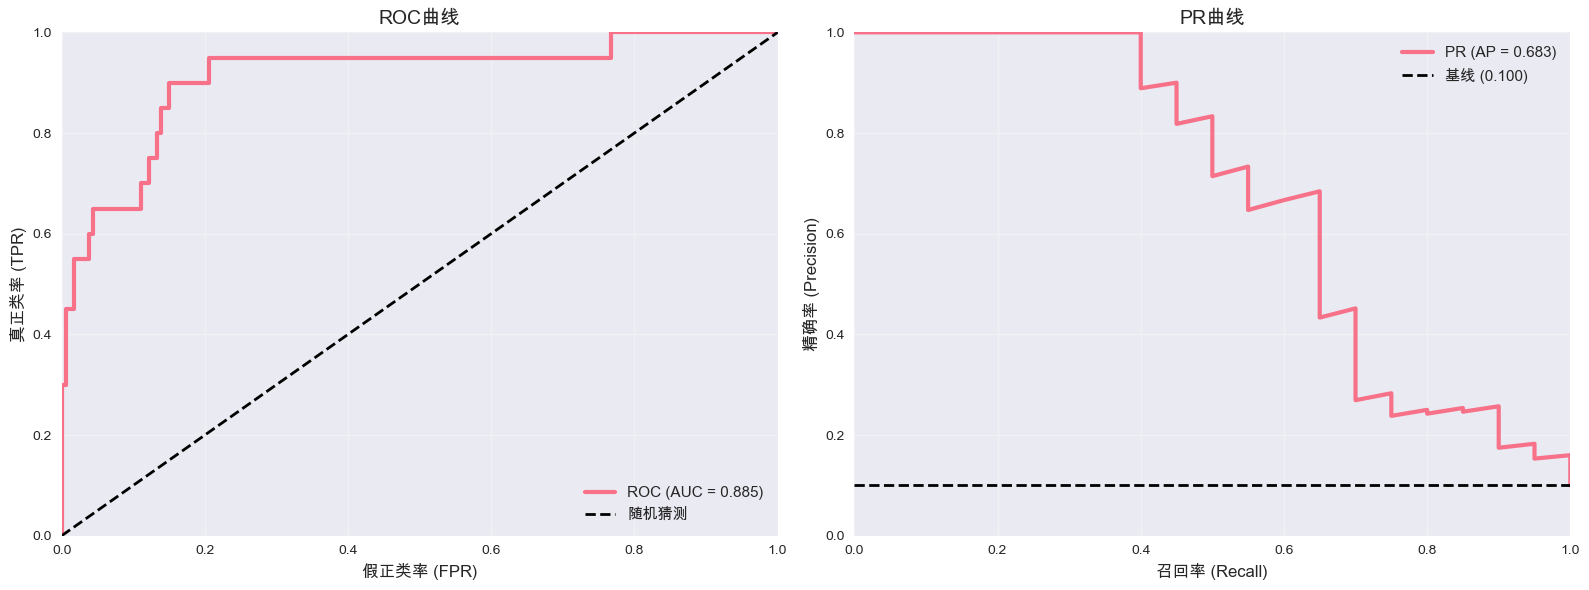


ROC vs PR曲线:
  - ROC: 关注整体分类性能，对不平衡数据可能过于乐观
  - PR: 更关注正类，对不平衡数据更严格
  - 类别平衡: 两者都可用
  - 类别不平衡: 优先使用PR曲线


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC曲线
axes[0].plot(fpr, tpr, linewidth=3, label=f'ROC (AUC = {auc_score:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='随机猜测')
axes[0].set_xlabel('假正类率 (FPR)', fontsize=12)
axes[0].set_ylabel('真正类率 (TPR)', fontsize=12)
axes[0].set_title('ROC曲线', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# PR曲线
axes[1].plot(recall_curve, precision_curve, linewidth=3,
             label=f'PR (AP = {ap_score:.3f})')
axes[1].axhline(y=baseline, color='k', linestyle='--', linewidth=2,
                label=f'基线 ({baseline:.3f})')
axes[1].set_xlabel('召回率 (Recall)', fontsize=12)
axes[1].set_ylabel('精确率 (Precision)', fontsize=12)
axes[1].set_title('PR曲线', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print('\nROC vs PR曲线:')
print('  - ROC: 关注整体分类性能，对不平衡数据可能过于乐观')
print('  - PR: 更关注正类，对不平衡数据更严格')
print('  - 类别平衡: 两者都可用')
print('  - 类别不平衡: 优先使用PR曲线')

## 6. 交叉验证

### 6.1 交叉验证原理

**为什么需要交叉验证？**
- 单次train/test split可能不够稳定
- 充分利用有限的数据
- 更可靠地评估模型泛化能力

**K-Fold交叉验证：**
1. 将数据分成K份
2. 每次用K-1份训练，1份验证
3. 重复K次，得到K个性能分数
4. 计算平均值和标准差

---

### 6.2 K-Fold交叉验证

In [9]:
# 使用乳腺癌数据集
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print('乳腺癌数据集:')
print(f'  样本数: {len(X_cancer)}')
print(f'  特征数: {X_cancer.shape[1]}')
print(f'  类别: {cancer.target_names}')
print(f'  类别分布: 恶性={np.sum(y_cancer==0)}, 良性={np.sum(y_cancer==1)}')

乳腺癌数据集:
  样本数: 569
  特征数: 30
  类别: ['malignant' 'benign']
  类别分布: 恶性=212, 良性=357


In [10]:
# 标准化特征
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

# 创建模型
lr_cancer = LogisticRegression(max_iter=10000, random_state=42)

# K-Fold交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_cancer, X_cancer_scaled, y_cancer, cv=kfold, scoring='accuracy')

print('5折交叉验证结果:')
print(f'  各折得分: {cv_scores}')
print(f'  平均准确率: {cv_scores.mean():.4f}')
print(f'  标准差: {cv_scores.std():.4f}')
print(f'  95%置信区间: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, '
      f'{cv_scores.mean() + 1.96*cv_scores.std():.4f}]')

5折交叉验证结果:
  各折得分: [0.97368421 0.98245614 0.96491228 0.99122807 0.97345133]
  平均准确率: 0.9771
  标准差: 0.0090
  95%置信区间: [0.9596, 0.9947]


### 6.3 Stratified K-Fold

In [11]:
# Stratified K-Fold（保持类别比例）
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = cross_val_score(
    lr_cancer, X_cancer_scaled, y_cancer, 
    cv=stratified_kfold, scoring='accuracy'
)

print('\nStratified K-Fold vs 普通K-Fold:')
print('='*60)
print(f'{"方法":<25} {"平均准确率":<15} {"标准差":<15}')
print('-'*60)
print(f'{"K-Fold":<25} {cv_scores.mean():<15.4f} {cv_scores.std():<15.4f}')
print(f'{"Stratified K-Fold":<25} {stratified_scores.mean():<15.4f} {stratified_scores.std():<15.4f}')
print('='*60)

print('\n说明:')
print('  - Stratified K-Fold确保每折中的类别比例与原数据集相同')
print('  - 对于类别不平衡的数据集，推荐使用Stratified K-Fold')


Stratified K-Fold vs 普通K-Fold:
方法                        平均准确率           标准差            
------------------------------------------------------------
K-Fold                    0.9771          0.0090         
Stratified K-Fold         0.9737          0.0166         

说明:
  - Stratified K-Fold确保每折中的类别比例与原数据集相同
  - 对于类别不平衡的数据集，推荐使用Stratified K-Fold


### 6.4 可视化交叉验证结果

逻辑回归: 0.9737 ± 0.0166
SVM: 0.9754 ± 0.0195
决策树: 0.9280 ± 0.0230
随机森林: 0.9561 ± 0.0123


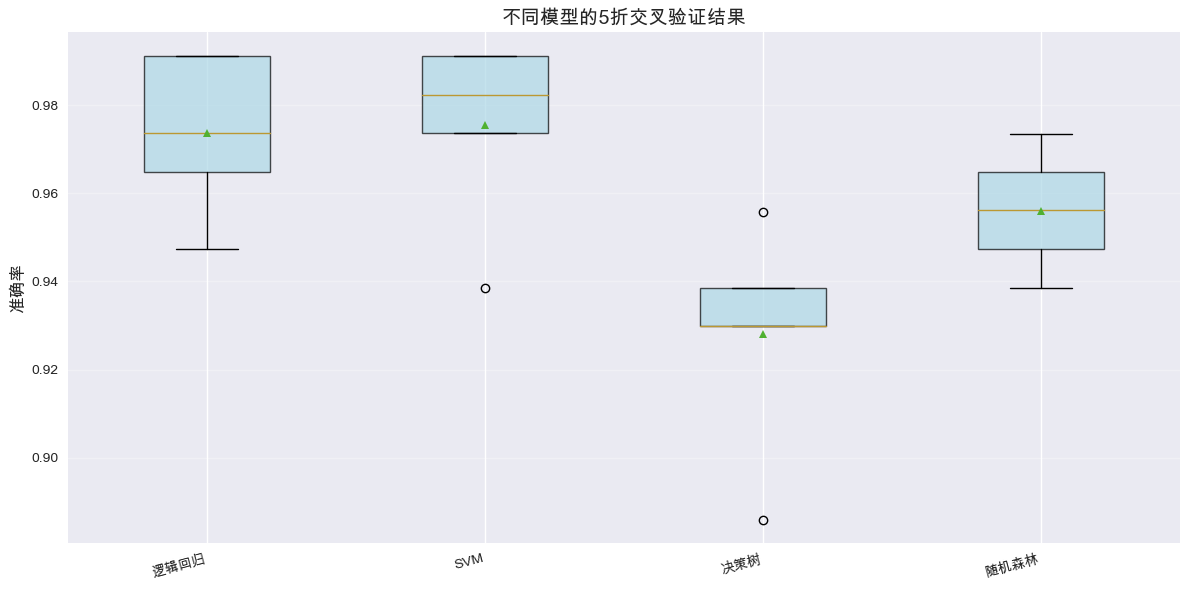

In [12]:
# 对比多个模型的交叉验证结果
models_cv = {
    '逻辑回归': LogisticRegression(max_iter=10000, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    '决策树': DecisionTreeClassifier(max_depth=5, random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, random_state=42)
}

cv_results = {}

for name, model in models_cv.items():
    scores = cross_val_score(
        model, X_cancer_scaled, y_cancer,
        cv=stratified_kfold, scoring='accuracy'
    )
    cv_results[name] = scores
    print(f'{name}: {scores.mean():.4f} ± {scores.std():.4f}')

# 可视化
plt.figure(figsize=(12, 6))
positions = range(len(cv_results))
bp = plt.boxplot([scores for scores in cv_results.values()],
                  labels=cv_results.keys(),
                  patch_artist=True,
                  showmeans=True)

# 美化箱线图
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

plt.ylabel('准确率', fontsize=12)
plt.title('不同模型的5折交叉验证结果', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## 7. 学习曲线

### 7.1 学习曲线原理

**学习曲线（Learning Curve）：**
- X轴：训练样本数
- Y轴：模型性能（准确率、损失等）
- 展示训练集和验证集的性能变化

**用途：**
- 诊断模型是否过拟合或欠拟合
- 判断是否需要更多数据
- 评估模型的学习能力

**典型模式：**
- **过拟合**: 训练分数高，验证分数低，两者差距大
- **欠拟合**: 两者都低，差距小
- **良好拟合**: 两者都高，差距小

---

### 7.2 绘制学习曲线

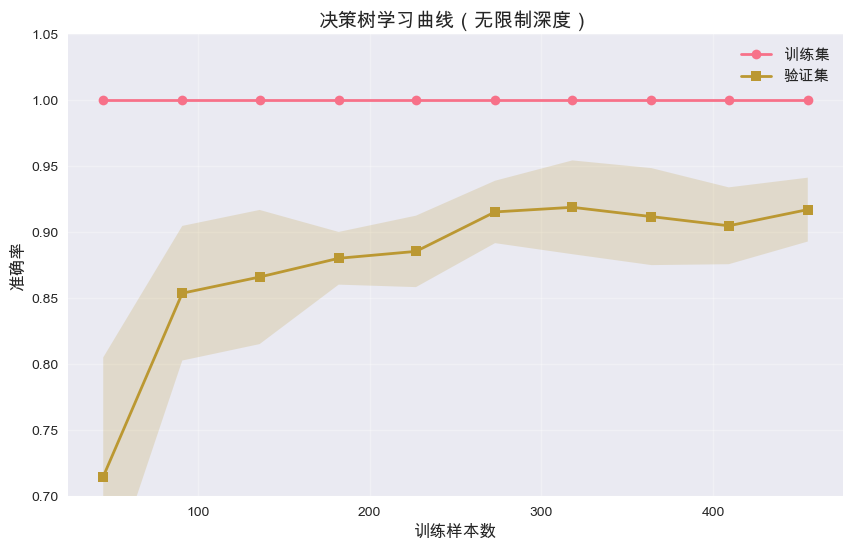


决策树学习曲线（无限制深度） - 诊断:
  最终训练准确率: 1.0000
  最终验证准确率: 0.9173
  差距: 0.0827
  → 模型表现良好


In [13]:
def plot_learning_curve(estimator, X, y, title='学习曲线', cv=5):
    """绘制学习曲线"""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', linewidth=2, label='训练集')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                     alpha=0.2)
    plt.plot(train_sizes, val_mean, 's-', linewidth=2, label='验证集')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                     alpha=0.2)
    
    plt.xlabel('训练样本数', fontsize=12)
    plt.ylabel('准确率', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim([0.7, 1.05])
    plt.show()
    
    # 诊断
    final_gap = train_mean[-1] - val_mean[-1]
    print(f'\n{title} - 诊断:')
    print(f'  最终训练准确率: {train_mean[-1]:.4f}')
    print(f'  最终验证准确率: {val_mean[-1]:.4f}')
    print(f'  差距: {final_gap:.4f}')
    
    if final_gap > 0.1:
        print('  → 可能过拟合，考虑正则化或减少模型复杂度')
    elif val_mean[-1] < 0.8:
        print('  → 可能欠拟合，考虑增加模型复杂度或更多特征')
    else:
        print('  → 模型表现良好')

# 测试决策树（容易过拟合）
plot_learning_curve(
    DecisionTreeClassifier(random_state=42),
    X_cancer_scaled, y_cancer,
    title='决策树学习曲线（无限制深度）'
)

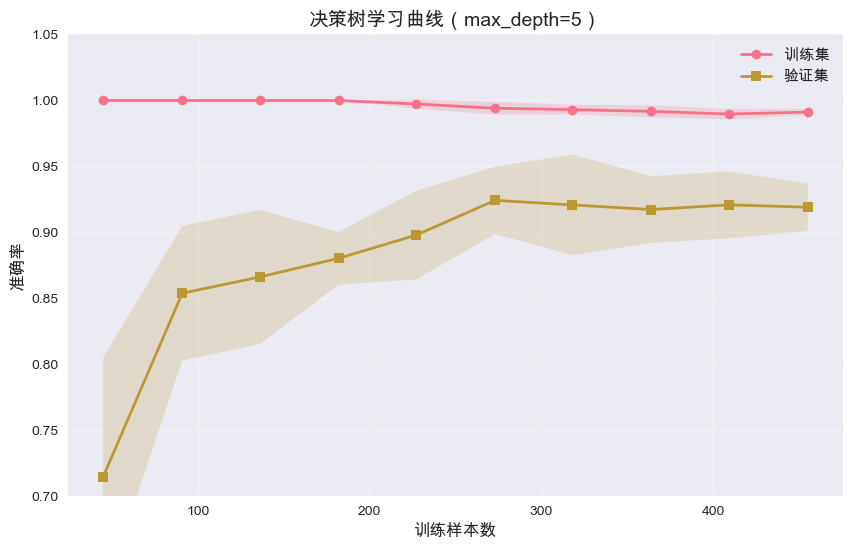


决策树学习曲线（max_depth=5） - 诊断:
  最终训练准确率: 0.9912
  最终验证准确率: 0.9191
  差距: 0.0721
  → 模型表现良好


In [14]:
# 测试正则化后的决策树
plot_learning_curve(
    DecisionTreeClassifier(max_depth=5, random_state=42),
    X_cancer_scaled, y_cancer,
    title='决策树学习曲线（max_depth=5）'
)

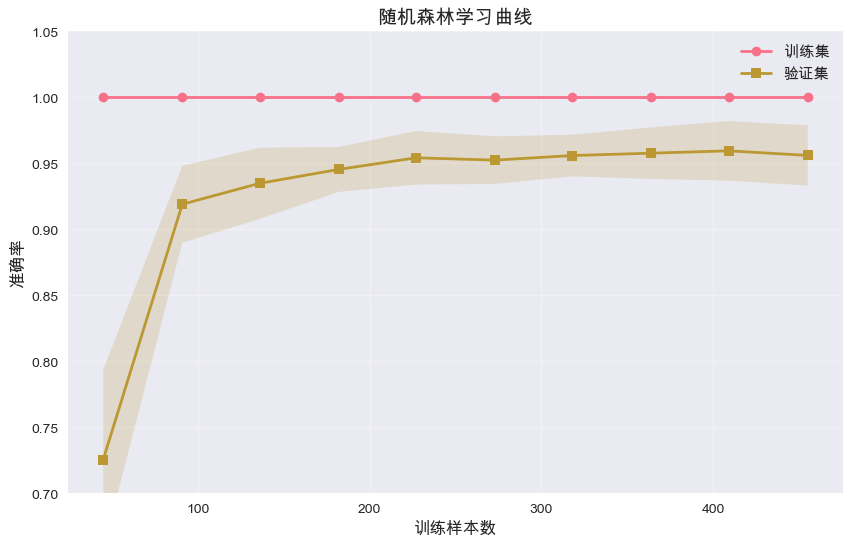


随机森林学习曲线 - 诊断:
  最终训练准确率: 1.0000
  最终验证准确率: 0.9561
  差距: 0.0439
  → 模型表现良好


In [15]:
# 测试随机森林
plot_learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_cancer_scaled, y_cancer,
    title='随机森林学习曲线'
)

## 8. 验证曲线

### 8.1 验证曲线原理

**验证曲线（Validation Curve）：**
- X轴：某个超参数的值
- Y轴：模型性能
- 展示不同参数值对性能的影响

**用途：**
- 可视化超参数的影响
- 找到最佳参数范围
- 理解过拟合和欠拟合

---

### 8.2 绘制验证曲线

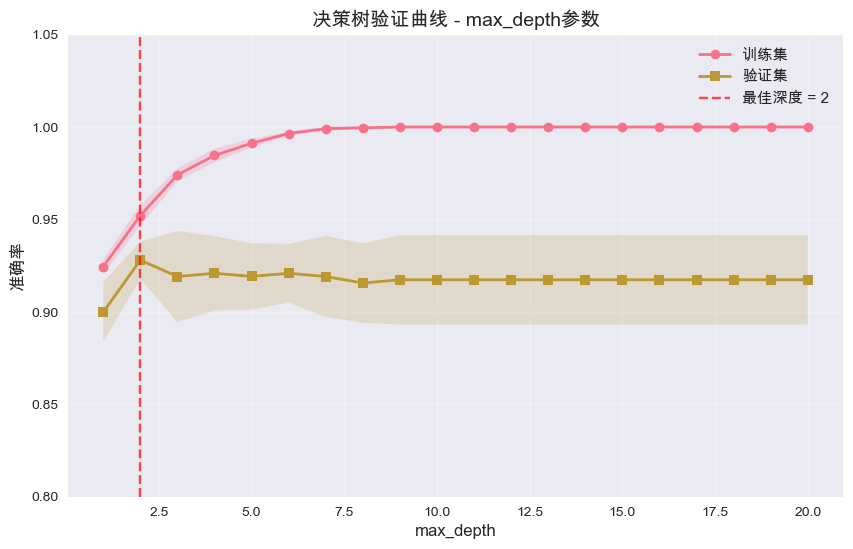

最佳max_depth: 2
对应验证准确率: 0.9280


In [16]:
# 测试决策树的max_depth参数
param_range = range(1, 21)

train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_cancer_scaled, y_cancer,
    param_name='max_depth',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, 'o-', linewidth=2, label='训练集')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std,
                 alpha=0.2)
plt.plot(param_range, val_mean, 's-', linewidth=2, label='验证集')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std,
                 alpha=0.2)

# 标记最佳值
best_idx = np.argmax(val_mean)
best_depth = param_range[best_idx]
plt.axvline(x=best_depth, color='red', linestyle='--', alpha=0.7,
            label=f'最佳深度 = {best_depth}')

plt.xlabel('max_depth', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.title('决策树验证曲线 - max_depth参数', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.8, 1.05])
plt.show()

print(f'最佳max_depth: {best_depth}')
print(f'对应验证准确率: {val_mean[best_idx]:.4f}')

## 9. 超参数调优

### 9.1 Grid Search vs Random Search

**Grid Search (网格搜索):**
- 遍历所有参数组合
- 详尽但耗时
- 适合参数空间较小

**Random Search (随机搜索):**
- 随机采样参数组合
- 更高效
- 适合参数空间大或连续参数

---

### 9.2 Grid Search实战

In [17]:
# 定义参数网格
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 创建GridSearchCV
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 训练
print('开始Grid Search...')
grid_search.fit(X_cancer_scaled, y_cancer)

print(f'\n最佳参数: {grid_search.best_params_}')
print(f'最佳交叉验证得分: {grid_search.best_score_:.4f}')
print(f'测试的参数组合数: {len(grid_search.cv_results_["params"])}')

开始Grid Search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

最佳参数: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
最佳交叉验证得分: 0.9209
测试的参数组合数: 36


In [18]:
# 查看所有结果
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

print('\nTop 10参数组合:')
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10).to_string(index=False))


Top 10参数组合:
                                                          params  mean_test_score  std_test_score  rank_test_score
 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}         0.920897        0.020073                1
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}         0.920882        0.012649                2
 {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}         0.920866        0.020996                3
 {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}         0.919143        0.020364                4
 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}         0.919143        0.017955                5
 {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}         0.919112        0.024625                6
 {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}         0.919112        0.024625                6
 {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}   

### 9.3 Random Search实战

In [19]:
from scipy.stats import randint, uniform

# 定义参数分布
param_distributions = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# 创建RandomizedSearchCV
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions,
    n_iter=50,  # 随机尝试50次
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 训练
print('开始Random Search...')
random_search.fit(X_cancer_scaled, y_cancer)

print(f'\n最佳参数: {random_search.best_params_}')
print(f'最佳交叉验证得分: {random_search.best_score_:.4f}')

print('\nGrid Search vs Random Search:')
print(f'  Grid Search最佳得分: {grid_search.best_score_:.4f}')
print(f'  Random Search最佳得分: {random_search.best_score_:.4f}')

开始Random Search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

最佳参数: {'max_depth': 11, 'min_samples_leaf': 8, 'min_samples_split': 8}
最佳交叉验证得分: 0.9385

Grid Search vs Random Search:
  Grid Search最佳得分: 0.9209
  Random Search最佳得分: 0.9385


## 10. 综合实战：模型对比与选择

### 10.1 加载数据

In [20]:
# 使用乳腺癌数据集进行完整的模型对比
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer_scaled, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

print(f'训练集: {X_train.shape}')
print(f'测试集: {X_test.shape}')

训练集: (455, 30)
测试集: (114, 30)


### 10.2 训练多个模型

In [21]:
# 定义多个模型
models_final = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# 训练并评估
results_final = []

for name, model in models_final.items():
    print(f'\n训练 {name}...')
    
    # 训练
    model.fit(X_train, y_train)
    
    # 预测
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # 交叉验证
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    results_final.append({
        '模型': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f'  Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, CV: {cv_scores.mean():.4f}±{cv_scores.std():.4f}')

# 转换为DataFrame
results_final_df = pd.DataFrame(results_final).sort_values('AUC', ascending=False)

print('\n' + '='*100)
print('所有模型性能对比')
print('='*100)
print(results_final_df.to_string(index=False))
print('='*100)


训练 Logistic Regression...
  Accuracy: 0.9825, AUC: 0.9954, CV: 0.9802±0.0128

训练 SVM (RBF)...
  Accuracy: 0.9825, AUC: 0.9950, CV: 0.9714±0.0179

训练 Decision Tree...
  Accuracy: 0.9211, AUC: 0.9163, CV: 0.9319±0.0213

训练 Random Forest...
  Accuracy: 0.9561, AUC: 0.9937, CV: 0.9538±0.0235

训练 Gradient Boosting...
  Accuracy: 0.9561, AUC: 0.9907, CV: 0.9582±0.0108

所有模型性能对比
                 模型  Accuracy  Precision   Recall  F1-Score      AUC  CV Mean   CV Std
Logistic Regression  0.982456   0.986111 0.986111  0.986111 0.995370 0.980220 0.012815
          SVM (RBF)  0.982456   0.986111 0.986111  0.986111 0.995040 0.971429 0.017855
      Random Forest  0.956140   0.958904 0.972222  0.965517 0.993717 0.953846 0.023466
  Gradient Boosting  0.956140   0.946667 0.986111  0.965986 0.990741 0.958242 0.010767
      Decision Tree  0.921053   0.956522 0.916667  0.936170 0.916336 0.931868 0.021308


### 10.3 可视化对比

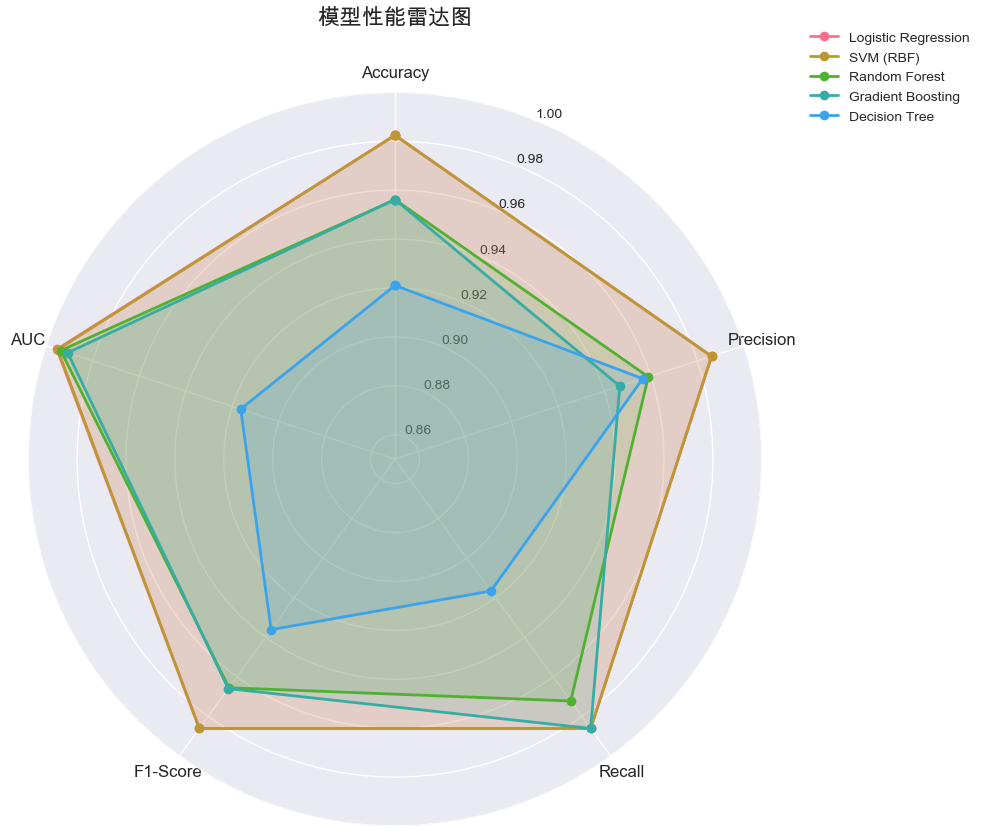

In [22]:
# 绘制雷达图
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
N = len(categories)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0.85, 1.0)

for idx, row in results_final_df.iterrows():
    values = row[categories].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['模型'])
    ax.fill(angles, values, alpha=0.15)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.title('模型性能雷达图', size=16, y=1.08)
plt.tight_layout()
plt.show()

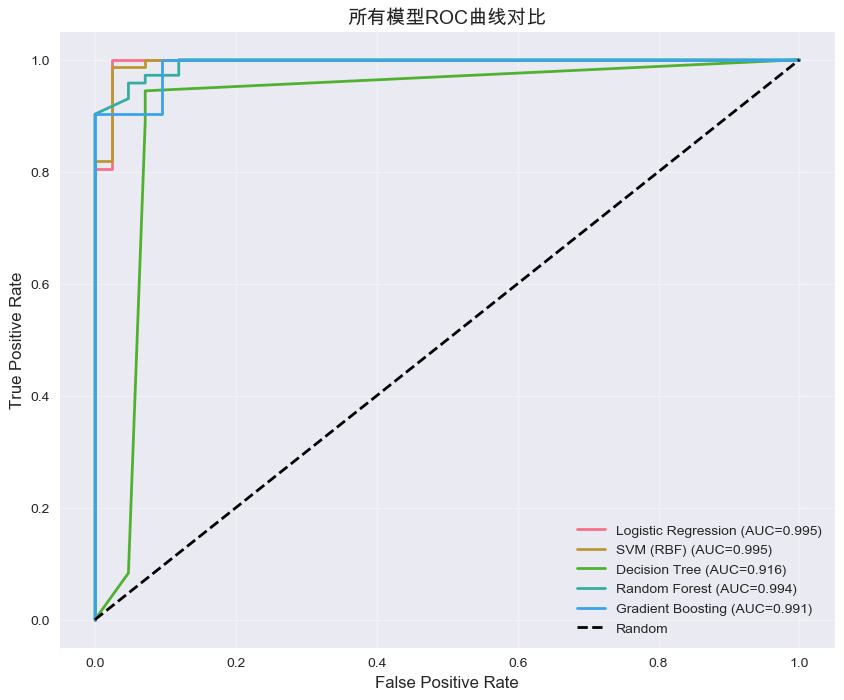

In [23]:
# 绘制ROC曲线对比
plt.figure(figsize=(10, 8))

for name, model in models_final.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('所有模型ROC曲线对比', fontsize=14)
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

### 10.4 最佳模型详细分析

最佳模型: Logistic Regression
AUC得分: 0.9954


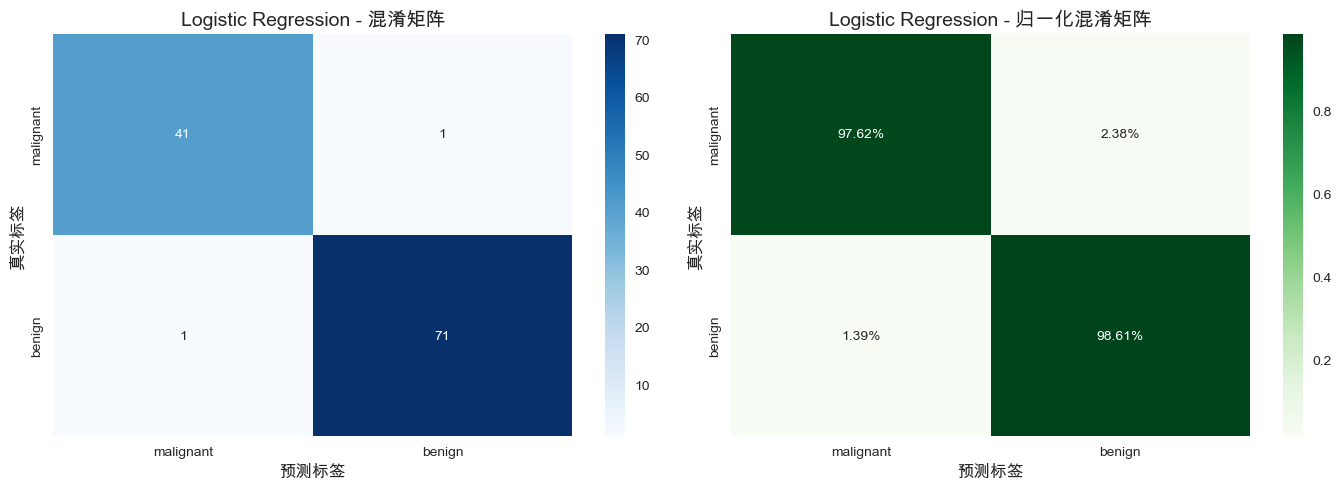


Logistic Regression分类报告:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [24]:
# 选择最佳模型
best_model_name = results_final_df.iloc[0]['模型']
best_model = models_final[best_model_name]

print(f'最佳模型: {best_model_name}')
print(f'AUC得分: {results_final_df.iloc[0]["AUC"]:.4f}')

# 预测
y_pred_best = best_model.predict(X_test)

# 混淆矩阵
cm_best = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 混淆矩阵
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=cancer.target_names,
            yticklabels=cancer.target_names)
axes[0].set_ylabel('真实标签', fontsize=12)
axes[0].set_xlabel('预测标签', fontsize=12)
axes[0].set_title(f'{best_model_name} - 混淆矩阵', fontsize=14)

# 归一化混淆矩阵
cm_normalized = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=cancer.target_names,
            yticklabels=cancer.target_names)
axes[1].set_ylabel('真实标签', fontsize=12)
axes[1].set_xlabel('预测标签', fontsize=12)
axes[1].set_title(f'{best_model_name} - 归一化混淆矩阵', fontsize=14)

plt.tight_layout()
plt.show()

# 分类报告
print(f'\n{best_model_name}分类报告:')
print(classification_report(y_test, y_pred_best, target_names=cancer.target_names))

## 11. 总结

### 11.1 知识点回顾

- ✅ **评估指标**: Accuracy、Precision、Recall、F1-Score、F-beta
- ✅ **类别不平衡**: 准确率的局限性，使用F1和AUC
- ✅ **ROC曲线**: TPR vs FPR，AUC解释
- ✅ **PR曲线**: Precision vs Recall，适合不平衡数据
- ✅ **交叉验证**: K-Fold、Stratified K-Fold
- ✅ **学习曲线**: 诊断过拟合和欠拟合
- ✅ **验证曲线**: 可视化超参数影响
- ✅ **超参数调优**: Grid Search、Random Search
- ✅ **模型选择**: 系统化对比多个模型

---

### 11.2 评估指标选择指南

| 场景 | 推荐指标 | 原因 |
|------|---------|------|
| 类别平衡 | Accuracy | 简单直观 |
| 类别不平衡 | F1-Score, AUC | 综合考虑 |
| 假阳性代价高 | Precision | 垃圾邮件检测 |
| 假阴性代价高 | Recall | 疾病诊断 |
| 需要排序 | AUC-ROC | 推荐系统 |
| 高度不平衡 | PR-AUC | 异常检测 |

---

### 11.3 模型评估最佳实践

1. **永远使用交叉验证**: 单次split不够可靠
2. **检查多个指标**: 不要只看准确率
3. **绘制学习曲线**: 诊断模型问题
4. **使用合适的评估指标**: 根据业务需求选择
5. **保留测试集**: 最后才在测试集上评估
6. **考虑计算成本**: 交叉验证和Grid Search很耗时
7. **记录所有实验**: 参数、指标、时间戳

---

### 11.4 常见错误

- ❌ 在测试集上调参（数据泄漏）
- ❌ 不平衡数据只看准确率
- ❌ 忘记特征标准化
- ❌ 过度拟合交叉验证集
- ❌ 不检查学习曲线
- ❌ 盲目相信默认参数

---

### 11.5 完整的机器学习工作流

```
1. 问题定义
   └─ 明确目标、评估指标

2. 数据准备
   ├─ 数据清洗
   ├─ 特征工程
   └─ 数据划分 (train/val/test)

3. 基线模型
   └─ 简单模型快速验证

4. 模型选择
   ├─ 尝试多个算法
   ├─ 交叉验证
   └─ 对比性能

5. 超参数调优
   ├─ Grid Search / Random Search
   ├─ 学习曲线分析
   └─ 验证曲线分析

6. 最终评估
   ├─ 在测试集上评估
   ├─ 多指标分析
   └─ 错误分析

7. 部署
   ├─ 模型保存
   ├─ 监控性能
   └─ 持续改进
```

---

### 11.6 下一步学习

恭喜你完成了监督学习的全部基础内容！接下来你可以：

1. **完成实战项目**
   - `projects/01_house_price_prediction/`
   - `projects/02_customer_churn_prediction/`

2. **进阶主题**
   - 无监督学习（聚类、降维）
   - 深度学习
   - 时间序列分析
   - 自然语言处理

3. **实践平台**
   - Kaggle竞赛
   - 真实项目
   - 开源贡献

---

**恭喜你完成模型评估与选择的学习！你现在已经掌握了完整的机器学习工作流！** 🎉🎉🎉